In [78]:
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

In [79]:
start = datetime.datetime(1998,1,1)
end = datetime.datetime.now()

In [80]:
AMT = pdr.get_data_yahoo('AMT', start, end)
AMT['Name'] = pd.Series()
AMT['Name'] = 'AMT'

CUBE = pdr.get_data_yahoo('CUBE', start, end)
CUBE['Name'] = pd.Series()
CUBE['Name'] = 'CUBE'

DEI = pdr.get_data_yahoo('DEI')
DEI['Name'] = pd.Series()
DEI['Name'] = 'DEI'

PLD = pdr.get_data_yahoo('PLD')
PLD['Name'] = pd.Series()
PLD['Name'] = 'PLD'

FR = pdr.get_data_yahoo('FR')
FR['Name'] = pd.Series()
FR['Name'] = 'FR'

MAA = pdr.get_data_yahoo('MAA')
MAA['Name'] = pd.Series()
MAA['Name'] = 'MAA'

MGP = pdr.get_data_yahoo('MGP')
MGP['Name'] = pd.Series()
MGP['Name'] = 'MGP'

MPW = pdr.get_data_yahoo('MPW')
MPW['Name'] = pd.Series()
MPW['Name'] = 'MPW'

WY = pdr.get_data_yahoo('WY')
WY['Name'] = pd.Series()
WY['Name'] = 'WY'

In [81]:
reit_df_list = [AMT, CUBE, DEI, PLD, FR, MAA, MGP, MPW, WY]
for reit in reit_df_list:
    reit.index = pd.to_datetime(reit.index)

In [82]:
daily_reit_dfs = AMT.append([CUBE, DEI, PLD, FR, MAA, MGP, MPW, WY])

In [83]:
daily_columns = daily_reit_dfs.columns.tolist()
daily_columns = daily_columns[-1:] + daily_columns[:-1]
daily_reit_dfs = daily_reit_dfs[daily_columns]

In [84]:
daily_reit_dfs

,Name,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,,
1998-02-27,AMT,18.000000,17.375000,17.375000,17.375000,50000.0,14.991437
1998-03-02,AMT,17.250000,17.000000,17.250000,17.250000,75000.0,14.883590
1998-03-03,AMT,17.125000,16.750000,17.125000,17.125000,35000.0,14.775733
1998-03-04,AMT,15.750000,15.500000,15.750000,15.750000,60000.0,13.589359
1998-03-05,AMT,16.125000,16.125000,16.125000,16.125000,400.0,13.912916
...,...,...,...,...,...,...,...
2020-01-27,WY,30.299999,29.990000,30.219999,30.170000,3170700.0,30.170000
2020-01-28,WY,30.500000,30.240000,30.320000,30.389999,3710900.0,30.389999
2020-01-29,WY,30.570000,30.080000,30.440001,30.100000,3477700.0,30.100000


In [88]:
#Create a daily lag to represent the price one day back. This will all for 'daily returns'
daily_reit_dfs['Daily Lag'] = daily_reit_dfs['Close'].shift(1)

In [91]:
daily_reit_dfs['Daily Returns'] = (daily_reit_dfs['Daily Lag']/daily_reit_dfs['Close']) - 1

In [92]:
daily_reit_dfs

,Name,High,Low,Open,Close,Volume,Adj Close,Daily Lag,Daily Returns
Date,,,,,,,,,
1998-02-27,AMT,18.000000,17.375000,17.375000,17.375000,50000.0,14.991437,NaN,NaN
1998-03-02,AMT,17.250000,17.000000,17.250000,17.250000,75000.0,14.883590,17.375000,0.007246
1998-03-03,AMT,17.125000,16.750000,17.125000,17.125000,35000.0,14.775733,17.250000,0.007299
1998-03-04,AMT,15.750000,15.500000,15.750000,15.750000,60000.0,13.589359,17.125000,0.087302
1998-03-05,AMT,16.125000,16.125000,16.125000,16.125000,400.0,13.912916,15.750000,-0.023256
...,...,...,...,...,...,...,...,...,...
2020-01-27,WY,30.299999,29.990000,30.219999,30.170000,3170700.0,30.170000,30.530001,0.011932
2020-01-28,WY,30.500000,30.240000,30.320000,30.389999,3710900.0,30.389999,30.170000,-0.007239
2020-01-29,WY,30.570000,30.080000,30.440001,30.100000,3477700.0,30.100000,30.389999,0.009635


In [93]:
reit_df_name_list = ['AMT', 'CUBE', 'DEI', 'PLD', 'FR', 'MAA', 'MGP', 'MPW', 'WY']
reit_df_dict = {}
for name in reit_df_name_list:
    df = daily_reit_dfs.loc[daily_reit_dfs.Name == name]
    reit_df_dict[name] = df

In [129]:
reit_df_dict.keys()

dict_keys(['AMT', 'CUBE', 'DEI', 'PLD', 'FR', 'MAA', 'MGP', 'MPW', 'WY'])

In [162]:
def plot_return_distributions(df_dict):
    for key in df_dict.keys():
        plt.style.use('ggplot')
        df_dict[key]['Daily Returns'].hist(bins = 25)
        plt.title(f'{key} Daily Return Histogram')
        plt.xlim(left = df_dict[key]['Daily Returns'].min() - 0.5, right = df_dict[key]['Daily Returns'].max() + 0.5)
        plt.tight_layout()
        plt.show();

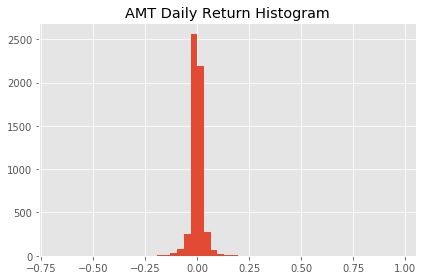

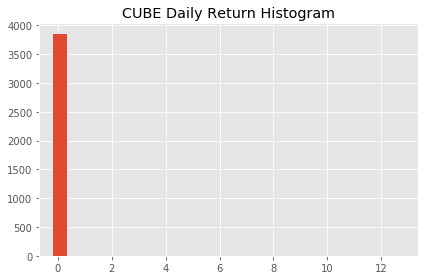

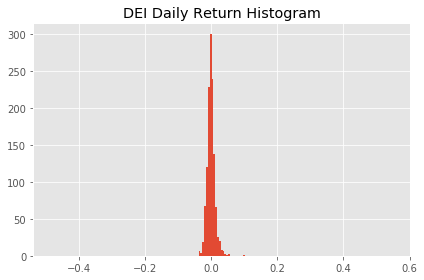

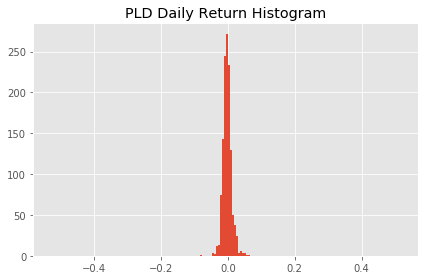

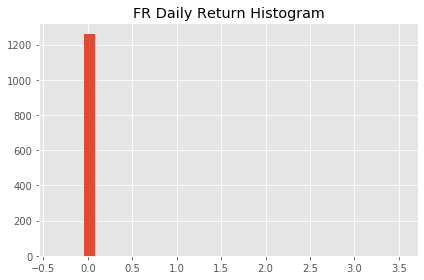

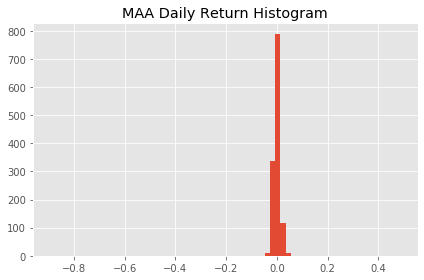

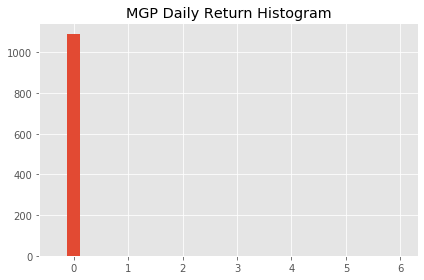

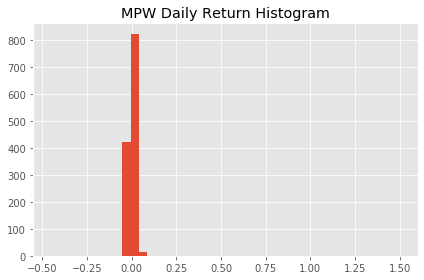

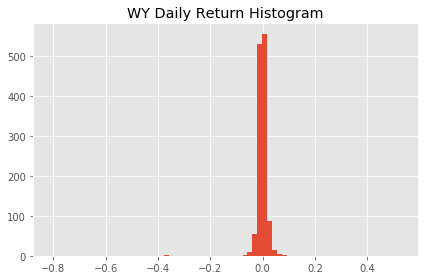

In [163]:
plot_return_distributions(reit_df_dict)